In [1]:
import sys
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
sys.path.append("..")

# news scraping
from src.zinfo.news_scraper import NewsScraper

# clustering
from src.zinfo.article_clustering import get_vectorized_titles
from src.zinfo.article_clustering import get_num_clusters_per_val
from src.zinfo.article_clustering import cluster_articles

# article selecting
from src.zinfo.article_selector import get_best_article_all_clusters

In [17]:
# scraper = NewsScraper('c4cf3a48098e49e9b5da8490c73856eb')
# trending_news = scraper.get_trending_articles_today()

scraping articles for 20 trends on 2021-08-12
scraped 862 articles


In [2]:
trending_news = pd.read_csv('trending_news.csv')

In [15]:
vectors, titles = get_vectorized_titles(trending_news)

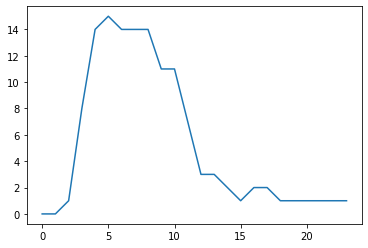

In [31]:
clusters_nums = get_num_clusters_per_val(np.array(vectors), 3, 2, 50, 2, 100)
plt.plot(clusters_nums)

In [32]:
clusters_nums

[0, 0, 1, 8, 14, 15, 14, 14, 14, 11, 11, 7, 3, 3, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1]

In [3]:
clusters = cluster_articles(trending_news)
summarized_news = get_best_article_all_clusters(clusters, trending_news)

clustering articles
eps_val: 0.24
min_samples: 2
selecting best articles out of each cluster


In [4]:
summarized_news

,date,title,url,topic,num_articles
520,2021-08-12T19:00:46Z,Surf Instructor Killed His Children and Claime...,https://www.memeorandum.com/210812/p91,QAnon,498
563,2021-08-12T09:47:00Z,Chloe Bennet leaves live-action Powerpuff Girl...,https://www.gamesradar.com/chloe-bennet-leaves...,Chloe Bennet,4
139,2021-08-12T17:49:12Z,Debbie Allen To Receive Governors Award At Thi...,https://deadline.com/2021/08/debbie-allen-emmy...,Whitney Houston,2
162,2021-08-12T18:05:03Z,‘Thor: The Dark World’ Director on Marvel Movi...,https://ohnotheydidnt.livejournal.com/12141119...,Arnold Schwarzenegger,2
211,2021-08-12T02:53:37Z,2022 MTV Video Music Award Nominations,https://ohnotheydidnt.livejournal.com/12140694...,Machine Gun Kelly,4
258,2021-08-12T16:15:00Z,UW Health to take part in pediatric COVID-19 v...,https://www.wisn.com/article/uw-health-to-take...,Immunocompromised,2
388,2021-08-12T14:24:22Z,"‘Home Sweet Home Alone:’ Ellie Kemper, Kenan T...",http://www.thewrap.com/home-sweet-home-alone-e...,Patriots,2
755,2021-08-12T05:50:00Z,Look to the sky tonight to get a glimpse of th...,https://www.hawaiinewsnow.com/2021/08/12/look-...,Meteor shower tonight,16
481,2021-08-12T05:54:46Z,MLB roundup: Bobby Dalbec's 5 RBIs help Red So...,https://www.channelnewsasia.com/sport/mlb-roun...,Jake Arrieta,3
456,2021-08-12T07:22:36Z,Means scheduled to start for Baltimore against...,https://www.thestar.com/sports/baseball/2021/0...,Chris Davis,2


In [6]:
trending_news.topic.value_counts()

Eagles                   80
Field of Dreams game     80
Immunocompromised        80
QAnon                    80
Afghanistan              80
Patriots                 80
Chris Davis              58
Arnold Schwarzenegger    53
Jeopardy! new host       49
Hunter Biden             45
India vs England         34
Machine Gun Kelly        34
Jake Arrieta             32
Meteor shower tonight    18
Tom Hanks son Chet       17
Brendan Fraser           13
Gary Payton II           10
Whitney Houston           8
Chloe Bennet              8
Danbury mall              3
Name: topic, dtype: int64